In [70]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def sigma_function(time,gamma):
    t_0 = 7
    if time < t_0:
        return np.sqrt(2*gamma)
    else:
        return 10**(-5)

In [4]:
def best_particle(X, objective_function):
    values = objective_function(X)
    best_particle = X[np.argmin(values)]
    return best_particle

In [5]:
def Reflection_spherical(X_old, V, radius,reflection_counter):
    global h
    N_particles = X_old.shape[0]
    X_new = X_old + h * V
    
    # Calculate norms for all particles
    norms = np.linalg.norm(X_new, axis=1)
    
    # Identify particles that need reflection
    reflect_mask = norms > radius
    original_counter = reflection_counter[0]
    reflection_counter[0] = original_counter + np.sum(reflect_mask)
    
    if np.any(reflect_mask):
        a = X_old[reflect_mask]
        b = V[reflect_mask]
        
        # Vectorized calculations
        p = 2 * np.sum(a * b, axis=1) / np.sum(b**2, axis=1)
        q = (np.sum(a**2, axis=1) - radius**2) / np.sum(b**2, axis=1)
        # Add epsilon and use np.maximum to avoid negative values under sqrt
        tau = -p/2 + np.sqrt(p**2/4 - q)
        NaN_mask = np.isnan(tau)
        num_nan = np.sum(NaN_mask)
        a[NaN_mask] = np.random.uniform(-512, 512, (num_nan, 2))
        b[NaN_mask] = np.random.uniform(-1, 1, (num_nan, 2))
        
        X_tau = a + tau[:, np.newaxis] * b
        
        # Calculate outward normals
        outward_normal = X_tau / np.linalg.norm(X_tau, axis=1)[:, np.newaxis]
         #the outward normal is calculated as the normalized position vector of the intersection point X_tau.
        #This works because for a circular (or spherical) boundary centered at the origin, 
        # the outward normal at any point on the boundary is simply the unit vector pointing from the origin to that point.
        
        # Calculate reflected velocities
        V_hat = b - 2 * np.sum(b * outward_normal, axis=1)[:, np.newaxis] * outward_normal
        
        # Update positions for reflected particles
        X_new[reflect_mask] = X_tau + (h - tau[:, np.newaxis]) * V_hat
        V[reflect_mask] = V_hat
    
    return X_new, V


In [6]:
def reflection_square(X_old, V, square_length, reflection_counter):
    global h
    X_new = X_old + h * V
    
    # Create masks for boundary crossings
    reflect_x = (np.abs(X_new[:, 0]) > square_length)
    reflect_y = (np.abs(X_new[:, 1]) > square_length)
    
    # Update reflection counter
    original_counter = reflection_counter[0]
    reflection_counter[0] = original_counter + np.sum(reflect_x) + np.sum(reflect_y)
    
    # Process X-axis reflections
    if np.any(reflect_x):
        a_x = X_old[reflect_x]
        b_x = V[reflect_x]
        
        # Calculate intersection times for X-boundary
        Vx = b_x[:, 0]
        boundary_x = np.where(Vx > 0, square_length, -square_length)
        tau_x = (boundary_x - a_x[:, 0]) / Vx
        
        # Handle Vx=0 cases (particles already outside boundary)
        tau_x = np.where(Vx == 0, h, tau_x)
        
        # Move to boundary and reflect velocity
        X_tau_x = a_x.copy()
        X_tau_x[:, 0] = boundary_x
        V_hat_x = b_x.copy()
        V_hat_x[:, 0] *= -1
        
        # Update positions and velocities
        X_new[reflect_x] = X_tau_x + (h - tau_x[:, None]) * V_hat_x
        V[reflect_x] = V_hat_x
    
    # Process Y-axis reflections
    if np.any(reflect_y):
        a_y = X_old[reflect_y]
        b_y = V[reflect_y]
        
        # Calculate intersection times for Y-boundary
        Vy = b_y[:, 1]
        boundary_y = np.where(Vy > 0, square_length, -square_length)
        tau_y = (boundary_y - a_y[:, 1]) / Vy
        
        # Handle Vy=0 cases
        tau_y = np.where(Vy == 0, h, tau_y)
        
        # Move to boundary and reflect velocity
        X_tau_y = a_y.copy()
        X_tau_y[:, 1] = boundary_y
        V_hat_y = b_y.copy()
        V_hat_y[:, 1] *= -1
        
        # Update positions and velocities
        X_new[reflect_y] = X_tau_y + (h - tau_y[:, None]) * V_hat_y
        V[reflect_y] = V_hat_y
    
    return X_new, V


In [7]:

def rastrigin_gradient(X):
    """
    Analytical gradient of the Rastrigin function.
    Parameters:
        X: np.ndarray of shape (N, D) or (D,)
    Returns:
        grad: np.ndarray of shape (N, D) or (D,)
    """
    X = np.atleast_2d(X)
    grad = 2 * X + 20 * np.pi * np.sin(2 * np.pi * X)
    return grad if X.shape[0] > 1 else grad[0]

In [8]:
def compute_gradients(X_new,objective_function , epsilon=1e-5):
    N_particles, D = X_new.shape
    gradients = np.zeros((N_particles, D))
    for i in range(N_particles):
        for d in range(D):
            x_plus = X_new[i].copy()
            x_minus = X_new[i].copy()
            x_plus[d] += epsilon
            x_minus[d] -= epsilon
            # Evaluate function at perturbed points
            f_plus = objective_function(x_plus)
            f_minus = objective_function(x_minus)
            # Central difference
            gradients[i, d] = ((f_plus - f_minus) / (2 * epsilon)).item()
    return gradients

In [59]:
def Kalman_Langevin(X_old, V_old,objective_function, gamma, sigma,radius, reflection_counter, square = True):
    # X: particle positions
    # weighted_average_X: weighted average of particle positions
    # V: particle velocities
    # Lambda: interaction coefficient
    # gamma: inertia coefficient
    # sigma: exploration coefficient
    # returns updated X, weighted_average_X, V
    N_particles = X_old.shape[0]
    V_old = np.clip(V_old, -100, 100)

    global h
    if square == True:
        X_hat, V_hat = reflection_square(X_old,V_old,radius,reflection_counter)
    else:
        X_hat, V_hat = Reflection_spherical(X_old,V_old,radius,reflection_counter)
    V_hat = np.clip(V_hat, -100, 100)
    X_new = X_hat
    best_particle_X = best_particle(X_hat,objective_function)
    Q = X_new-best_particle_X
    covariance = np.dot(Q.T,Q)/N_particles
    covariance = np.clip(covariance, -1e10, 1e10)
    #gradients_of_particles = rastrigin_gradient(X_new)
    gradients_of_particles = compute_gradients(X_new,objective_function)
    #weighted_average_X = weighted_average(X_new,alpha,objective_function)
    V_new = V_hat - np.dot(gradients_of_particles,covariance)*h-gamma*V_hat*h+sigma*np.sqrt(h)*np.dot(np.random.randn(N_particles,N_particles),Q)
    V_new = np.clip(V_new, -100, 100)
    
    return X_new, V_new

In [10]:
def non_interacting_Kalman_Langevin(X_old, V_old,objective_function, gamma, sigma,radius, reflection_counter, square = True):
    # X: particle positions
    # weighted_average_X: weighted average of particle positions
    # V: particle velocities
    # Lambda: interaction coefficient
    # gamma: inertia coefficient
    # sigma: exploration coefficient
    # returns updated X, weighted_average_X, V
    N_particles = X_old.shape[0]

    global h
    if square == True:
        X_hat, V_hat = reflection_square(X_old,V_old,radius,reflection_counter)
    else:
        X_hat, V_hat = Reflection_spherical(X_old,V_old,radius,reflection_counter)
    
    X_new = X_hat
    best_particle_X = best_particle(X_hat,objective_function)
    Q = X_new-best_particle_X
    covariance = np.dot(Q.T,Q)/N_particles
    covariance = np.clip(covariance, -1e10, 1e10)
    gradients_of_particles = rastrigin_gradient(X_new)
    #gradients_of_particles = compute_gradients(X_new,objective_function)
    #weighted_average_X = weighted_average(X_new,alpha,objective_function)
    V_new = V_hat - gradients_of_particles*h-gamma*V_hat*h+sigma*np.sqrt(h)*np.random.randn(N_particles,2)
    
    
    
    return X_new, V_new

In [11]:
def rastrigin(X):
    A = 10
    X = np.atleast_2d(X)  # Ensures X is always 2D
    return A * X.shape[1] + np.sum(X**2 - A * np.cos(2 * np.pi * X), axis=1)

In [ ]:


#Grid search for optimal parameters
gamma = 1.75
N_particles = 100
radius = 5.12
objective_function = rastrigin
T = 10
h = 0.01
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-5.12, 5.12, 1000)
y = np.linspace(-5.12, 5.12, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

best_min = np.min(objective_function(particle_positions_X))
print("N_particles: ",N_particles,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
min_x, min_y = [0,0]

reflection_counter = [0]
plot_list = [0,50,100,200,300,400,500,600,700,800,900,999]
while time<T:
    iteration = int(time/h)
    #print(iteration)
    if iteration in plot_list:
        plt.figure(figsize=(10, 8))
        # Plotting

        plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        plt.colorbar(label='Egg Holder Function Value')
        plt.xlim(-5.12, 5.12)
        plt.ylim(-5.12, 5.12)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'KLD Results (N_p={N_particles}, γ={gamma:.2f}), Iteration: {iteration}')
        plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'wo', markersize=10, alpha=0.5)
        best_min_x, best_min_y = best_particle(particle_positions_X,objective_function)
        plt.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        plt.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')
    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = Kalman_Langevin(particle_positions_X, particle_velocities_V,objective_function,gamma,sigma,radius,reflection_counter, square = True)
    
    time += h

min_index = np.argmin(objective_function(particle_positions_X))

print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ",reflection_counter[0]) 



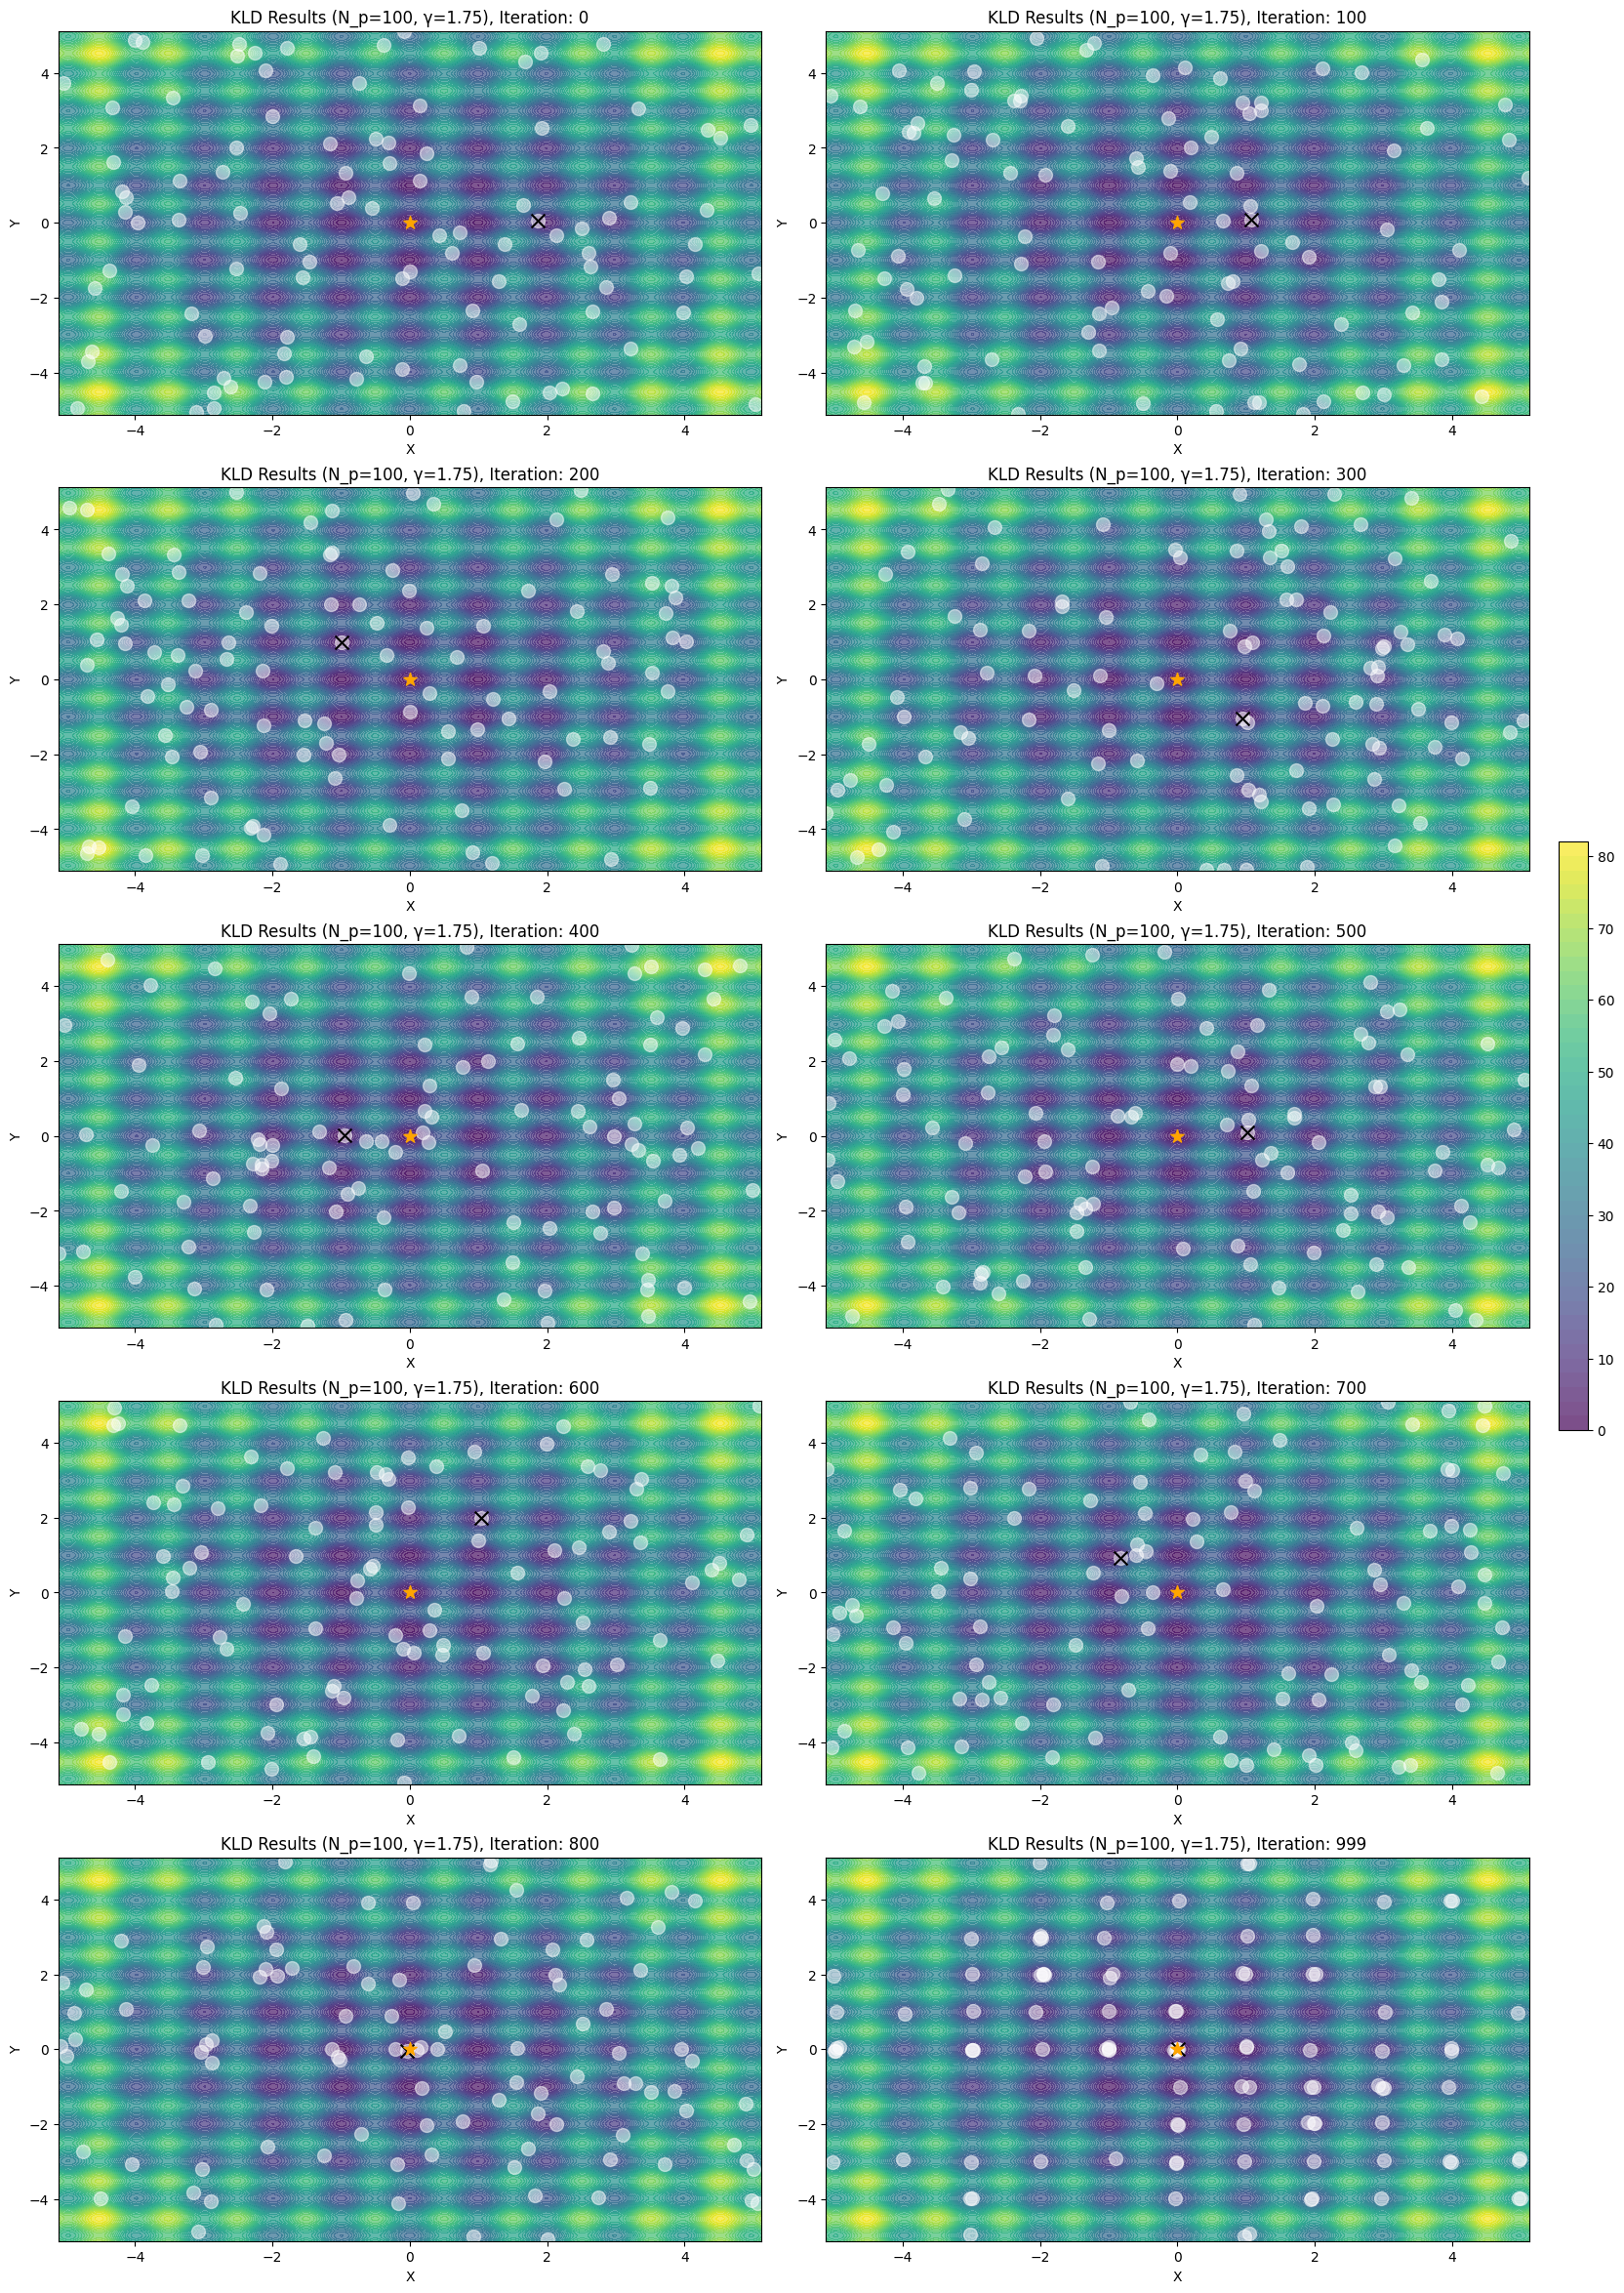

N_particles:  100 Lambda:  gamma:  1.75 objective: 
0 0 0.09194345803890869
Reflections:  3170


In [67]:
#Grid search for optimal parameters
gamma = 1.75
N_particles = 100
radius = 5.12
objective_function = rastrigin
T = 10
h = 0.01
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-5.12, 5.12, 1000)
y = np.linspace(-5.12, 5.12, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

min_x, min_y = [0, 0]

reflection_counter = [0]
plot_list = [0,100,200,300,400,500,600,700,800,999]

# Create a figure with subplots (5 rows and 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(16.54, 23.38),constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

cf = None  # Store the contourf object for colorbar

while time < T:
    iteration = int(time / h)
    if iteration in plot_list:
        index = plot_list.index(iteration)  # Get the index of the current iteration in plot_list
        ax = axes[index]  # Select the corresponding subplot
        
        # Plotting on the selected subplot
        cf = ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        ax.set_xlim(-5.12, 5.12)
        ax.set_ylim(-5.12, 5.12)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'KLD Results (N_p={N_particles}, γ={gamma:.2f}), Iteration: {iteration}')
        
        # Plot particle positions
        ax.plot(particle_positions_X[:, 0], particle_positions_X[:, 1], 'wo', markersize=10, alpha=0.5)
        
        # Highlight best particle and global minimum
        best_min_x, best_min_y = best_particle(particle_positions_X, objective_function)
        ax.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        ax.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')

    sigma = sigma_function(time,gamma)
    particle_positions_X, particle_velocities_V = Kalman_Langevin(
        particle_positions_X,
        particle_velocities_V,
        objective_function,
        gamma,
        sigma,
        radius,
        reflection_counter,
        square=True,
    )
    time += h

# Add a single colorbar to the right of all subplots
fig.colorbar(cf, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()
print("N_particles: ", N_particles, "Lambda: ", "gamma: ", gamma, "objective: ")
min_index = np.argmin(objective_function(particle_positions_X))
print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ", reflection_counter[0])


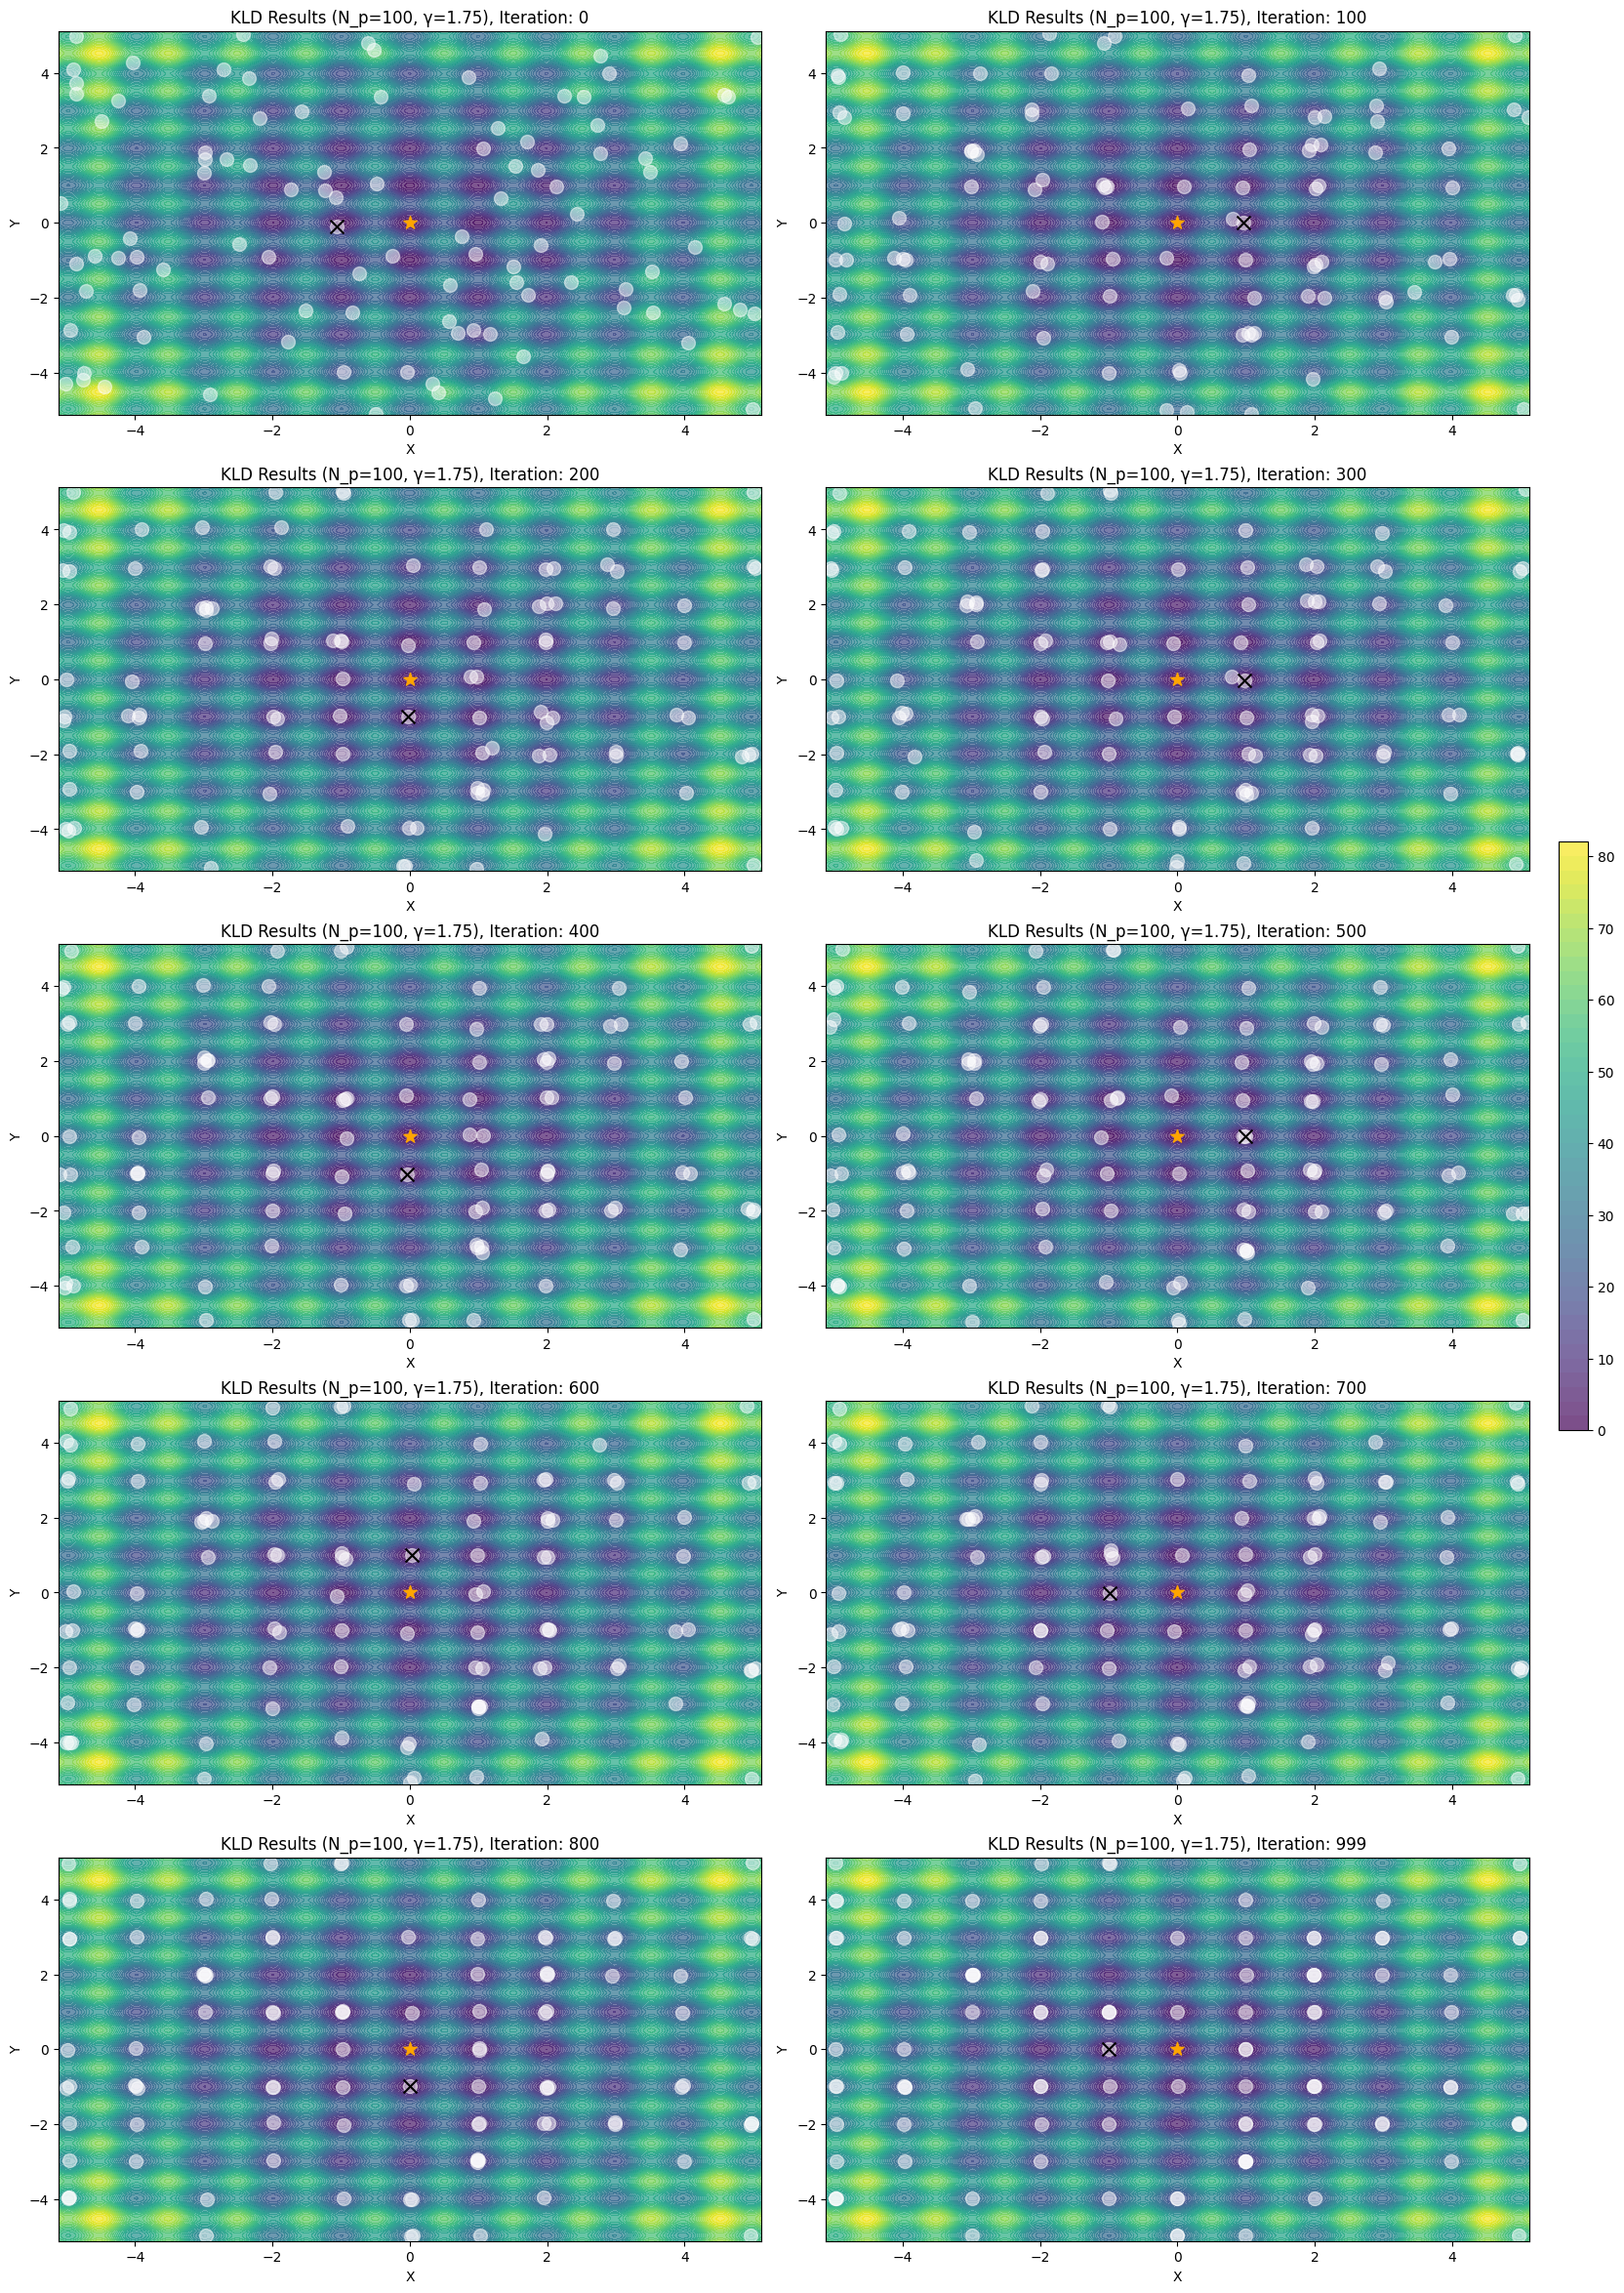

N_particles:  100 Lambda:  gamma:  1.75 objective: 
0 0 0.9957102973593521
Reflections:  44


In [66]:
#Grid search for optimal parameters
gamma = 1.75
N_particles = 100
radius = 5.12
objective_function = rastrigin
T = 10
h = 0.01
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-5.12, 5.12, 1000)
y = np.linspace(-5.12, 5.12, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

min_x, min_y = [0, 0]

reflection_counter = [0]
plot_list = [0,100,200,300,400,500,600,700,800,999]

# Create a figure with subplots (5 rows and 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(16.54, 23.38),constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

cf = None  # Store the contourf object for colorbar

while time < T:
    iteration = int(time / h)
    if iteration in plot_list:
        index = plot_list.index(iteration)  # Get the index of the current iteration in plot_list
        ax = axes[index]  # Select the corresponding subplot
        
        # Plotting on the selected subplot
        cf = ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        ax.set_xlim(-5.12, 5.12)
        ax.set_ylim(-5.12, 5.12)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'KLD Results (N_p={N_particles}, γ={gamma:.2f}), Iteration: {iteration}')
        
        # Plot particle positions
        ax.plot(particle_positions_X[:, 0], particle_positions_X[:, 1], 'wo', markersize=10, alpha=0.5)
        
        # Highlight best particle and global minimum
        best_min_x, best_min_y = best_particle(particle_positions_X, objective_function)
        ax.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        ax.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')

    sigma = sigma_function(time,gamma)
    particle_positions_X, particle_velocities_V = non_interacting_Kalman_Langevin(
        particle_positions_X,
        particle_velocities_V,
        objective_function,
        gamma,
        sigma,
        radius,
        reflection_counter,
        square=True,
    )
    time += h

# Add a single colorbar to the right of all subplots
fig.colorbar(cf, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()
print("N_particles: ", N_particles, "Lambda: ", "gamma: ", gamma, "objective: ")
min_index = np.argmin(objective_function(particle_positions_X))
print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ", reflection_counter[0])


In [23]:
def success_function(X, global_minima, objective_function):
    best_part= best_particle(X, objective_function)
    if global_minima.ndim == 1:
        distances = np.linalg.norm(best_part - global_minima)
    else:
        distances = np.linalg.norm(best_part - global_minima,axis=1)
    return np.any(distances < 0.2)

In [30]:
#Grid search for optimal parameters
N_particles = 50
square_length = 5.12
N_iter = 1000

objective_function = rastrigin
# Define the global minima
global_minima_rastrigin = np.array([0, 0])
success = 0
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)



gamma_values = [1.75]
#results = np.zeros((len(lambda_values), len(gamma_values)))
for j, gamma in enumerate(gamma_values):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
        
        while time < T:
            sigma = sigma_function(time,gamma)
            particle_positions_X, particle_velocities_V = Kalman_Langevin(particle_positions_X, particle_velocities_V, objective_function, gamma, sigma, square_length, reflection_count)
            time += h
        
        if success_function(particle_positions_X, global_minima_rastrigin, objective_function):
            success += 1
    
    success_rate = success / N_iter * 100
    
    print(f"Gamma: {gamma}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")



Gamma: 1.75, Success rate: 48.80%, Reflections: 2984


In [18]:
#Grid search for optimal parameters
N_particles = 10
square_length = 5.12
N_iter = 1000

objective_function = rastrigin
# Define the global minima
global_minima_rastrigin = np.array([0, 0])
success = 0
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

gamma = 1.75


n_particle_list = [10, 20, 50, 100, 200]
#results = np.zeros((len(lambda_values), len(gamma_values)))
for j, N_particles in enumerate(n_particle_list):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
        
        while time < T:
            sigma = sigma_function(time,gamma)
            particle_positions_X, particle_velocities_V = Kalman_Langevin(particle_positions_X, particle_velocities_V, objective_function, gamma, sigma, square_length, reflection_count)
            time += h
        
        if success_function(particle_positions_X, global_minima_rastrigin, objective_function):
            success += 1
    
    success_rate = success / N_iter * 100
    
    print(f"N_particles: {N_particles}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")



KeyboardInterrupt: 

In [19]:
#Grid search for optimal parameters
N_particles = 10
square_length = 5.12
N_iter = 1000
T= 10
h = 0.01
objective_function = rastrigin
# Define the global minima
global_minima_rastrigin = np.array([0, 0])
success = 0
particle_positions_X = np.random.uniform(-5.12,5.12,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

gamma = 1.75


n_particle_list = [10, 20, 50, 100, 200]
#results = np.zeros((len(lambda_values), len(gamma_values)))
for j, N_particles in enumerate(n_particle_list):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
        
        while time < T:
            sigma = sigma_function(time,gamma)
            particle_positions_X, particle_velocities_V = non_interacting_Kalman_Langevin(particle_positions_X, particle_velocities_V, objective_function, gamma, sigma, square_length, reflection_count)
            time += h
        
        if success_function(particle_positions_X, global_minima_rastrigin, objective_function):
            success += 1
    
    success_rate = success / N_iter * 100
    
    print(f"N_particles: {N_particles}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")



N_particles: 10, Success rate: 9.90%, Reflections: 3
N_particles: 20, Success rate: 17.10%, Reflections: 6
N_particles: 50, Success rate: 42.00%, Reflections: 19
N_particles: 100, Success rate: 64.40%, Reflections: 27
N_particles: 200, Success rate: 87.00%, Reflections: 53


In [42]:
def egg_holder(X):
    X = np.atleast_2d(X)
    x = X[:, 0]
    y = X[:, 1]
    return -(y + 47) * np.sin(np.sqrt(np.abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))

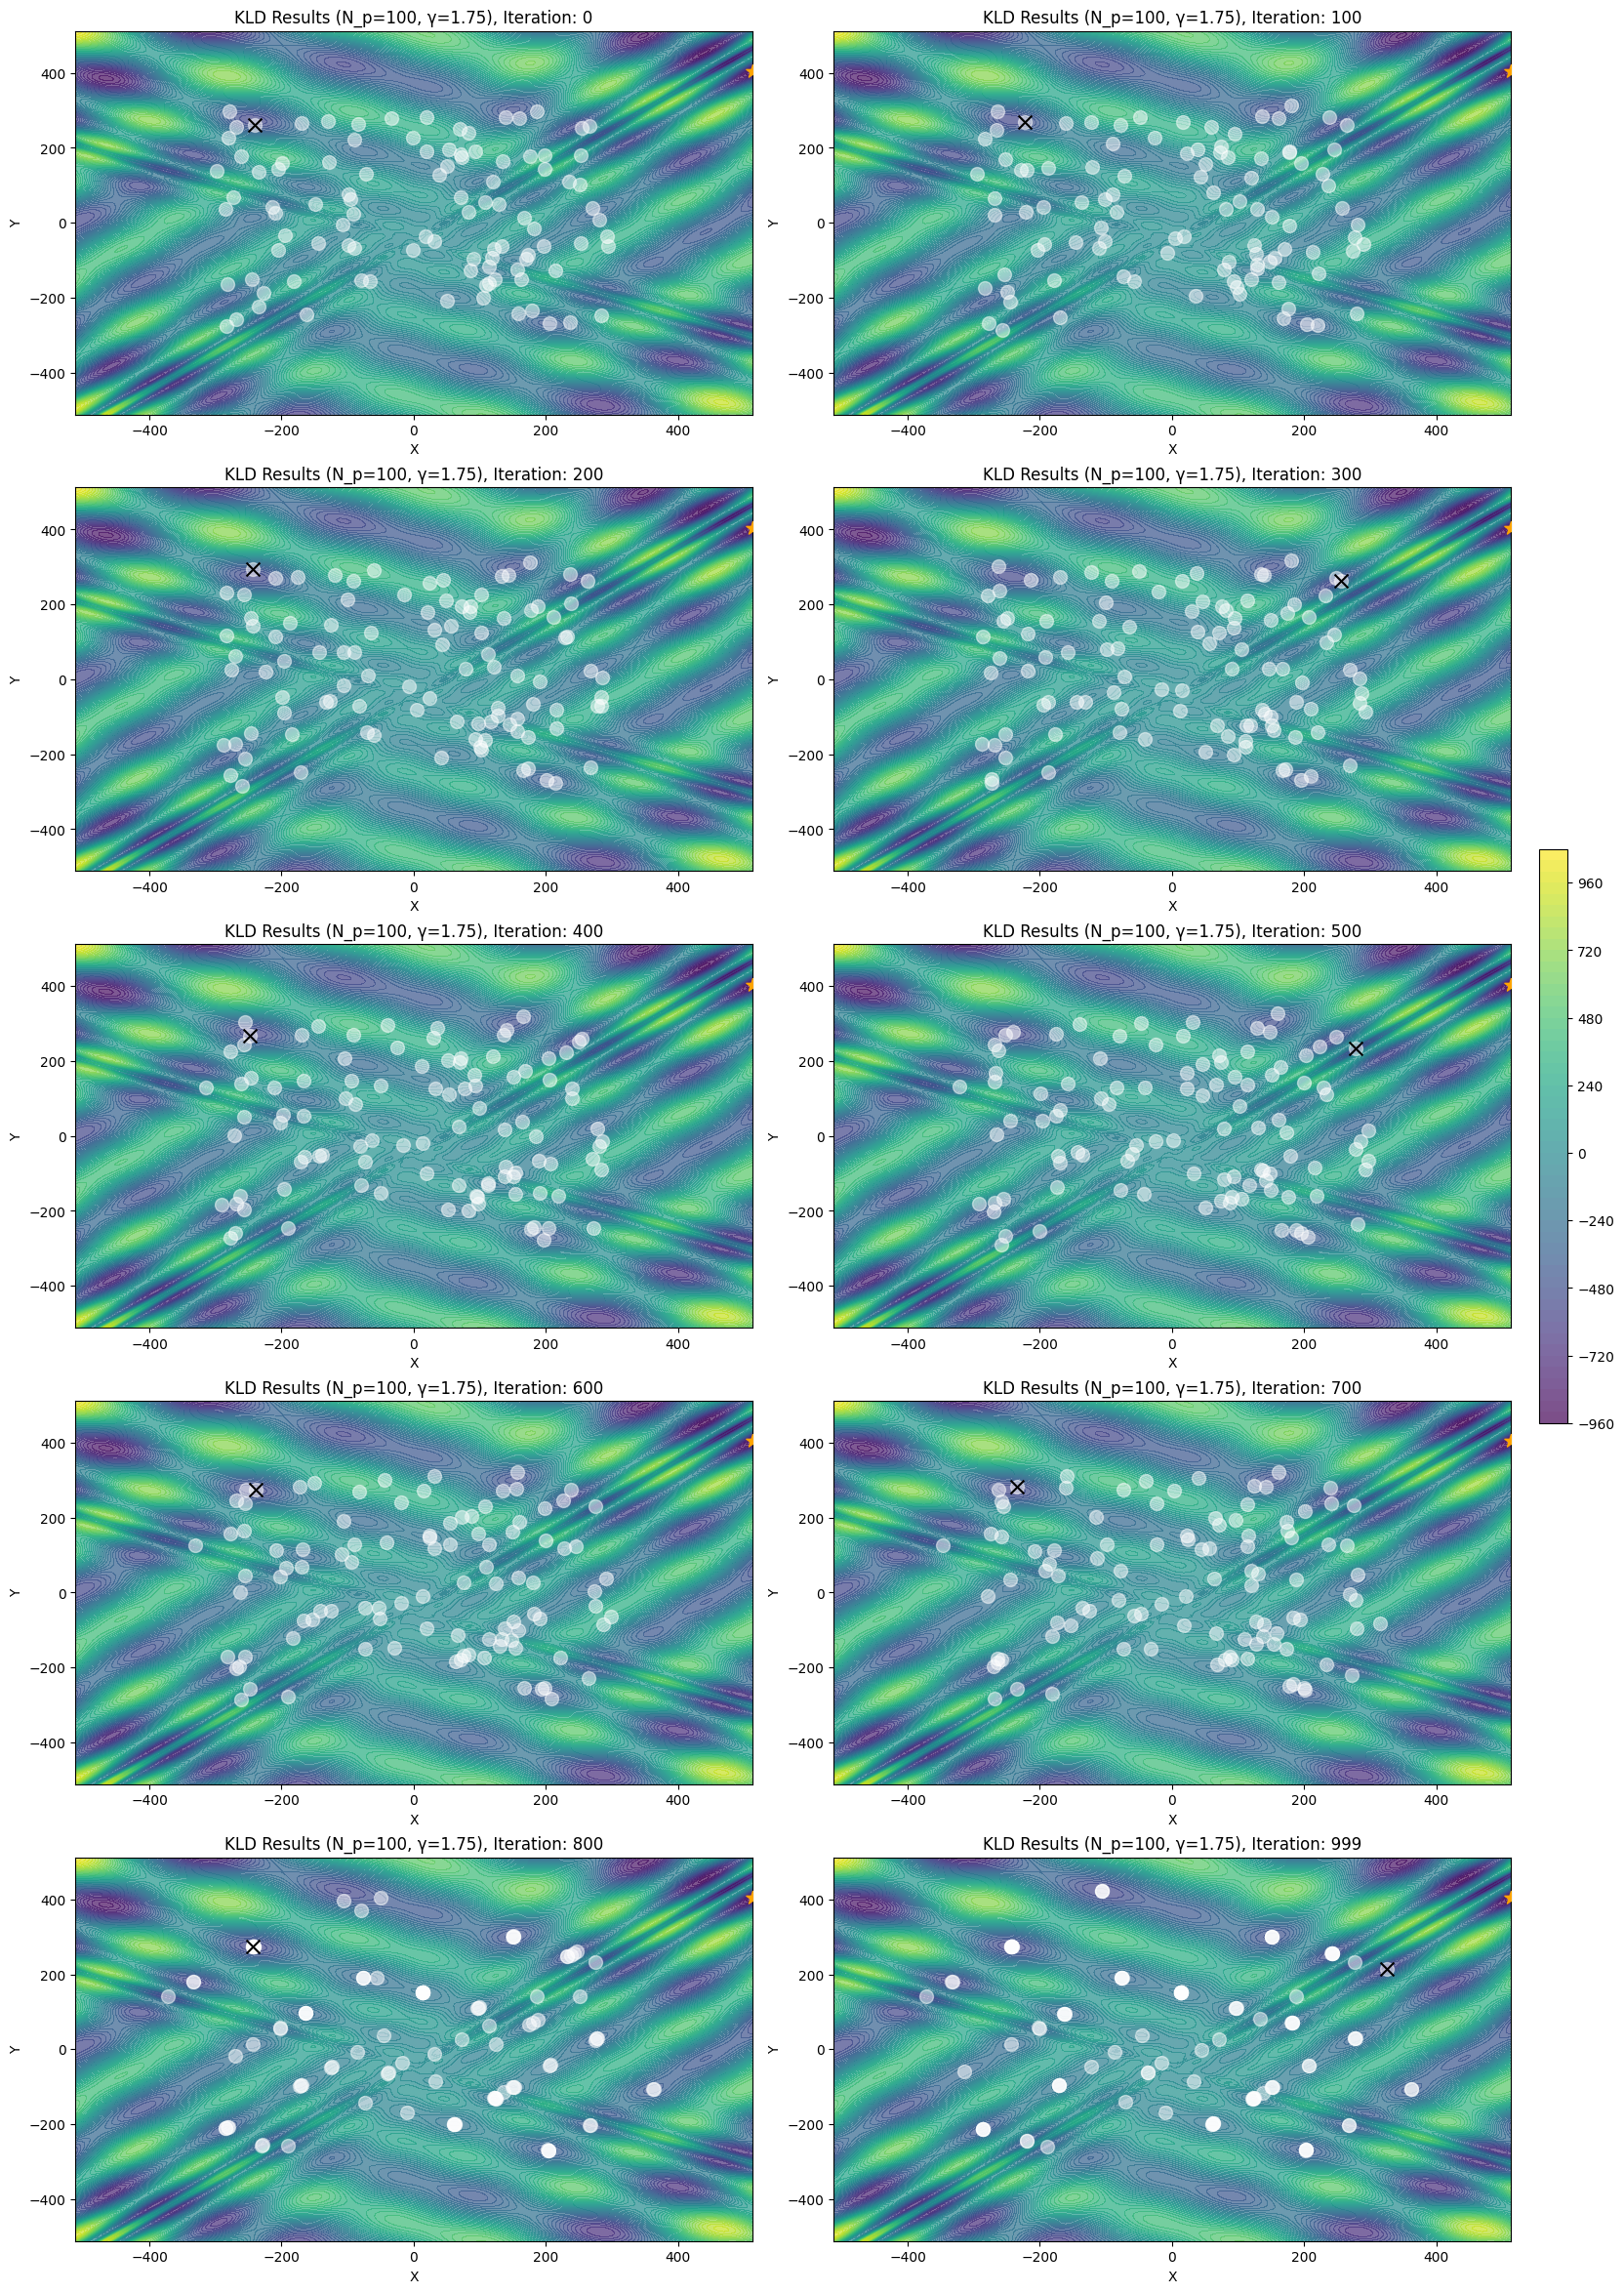

N_particles:  100 Lambda:  gamma:  1.75 objective: 
512 404.2319 -581.2281466811528
Reflections:  0


In [71]:
#Grid search for optimal parameters
gamma = 1.75
N_particles = 100
radius = 512
objective_function = egg_holder
T = 10
h = 0.01
particle_positions_X = np.random.uniform(-300,300,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
#particle_velocities_V = np.clip(particle_velocities_V, -100, 100)
time = 0
# Create a grid for the contour plot
x = np.linspace(-512, 512, 1000)
y = np.linspace(-512, 512, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

min_x, min_y = [512, 404.2319]

reflection_counter = [0]
plot_list = [0,100,200,300,400,500,600,700,800,999]

# Create a figure with subplots (5 rows and 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(16.54, 23.38),constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

cf = None  # Store the contourf object for colorbar

while time < T:
    iteration = int(time / h)
    if iteration in plot_list:
        index = plot_list.index(iteration)  # Get the index of the current iteration in plot_list
        ax = axes[index]  # Select the corresponding subplot
        
        # Plotting on the selected subplot
        cf = ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        ax.set_xlim(-512, 512)
        ax.set_ylim(-512, 512)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'KLD Results (N_p={N_particles}, γ={gamma:.2f}), Iteration: {iteration}')
        
        # Plot particle positions
        ax.plot(particle_positions_X[:, 0], particle_positions_X[:, 1], 'wo', markersize=10, alpha=0.5)
        
        # Highlight best particle and global minimum
        best_min_x, best_min_y = best_particle(particle_positions_X, objective_function)
        ax.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        ax.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')

    sigma = sigma_function(time,gamma*500*500)
    particle_positions_X, particle_velocities_V = Kalman_Langevin(
        particle_positions_X,
        particle_velocities_V,
        objective_function,
        gamma,
        sigma,
        radius,
        reflection_counter,
        square=True,
    )
    time += h

# Add a single colorbar to the right of all subplots
fig.colorbar(cf, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()
print("N_particles: ", N_particles, "Lambda: ", "gamma: ", gamma, "objective: ")
min_index = np.argmin(objective_function(particle_positions_X))
print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ", reflection_counter[0])
